In [21]:
from Bio import Phylo
import matplotlib.pyplot as plt
from Bio.Phylo.BaseTree import Clade, Tree as BioTree
import random
import numpy as np
from ete3 import Tree as Ete3Tree, TreeStyle
import re
import pandas as pd
from tabulate import tabulate

# LEITURA E PROCESSAMENTO DE ARVORE NEWICK

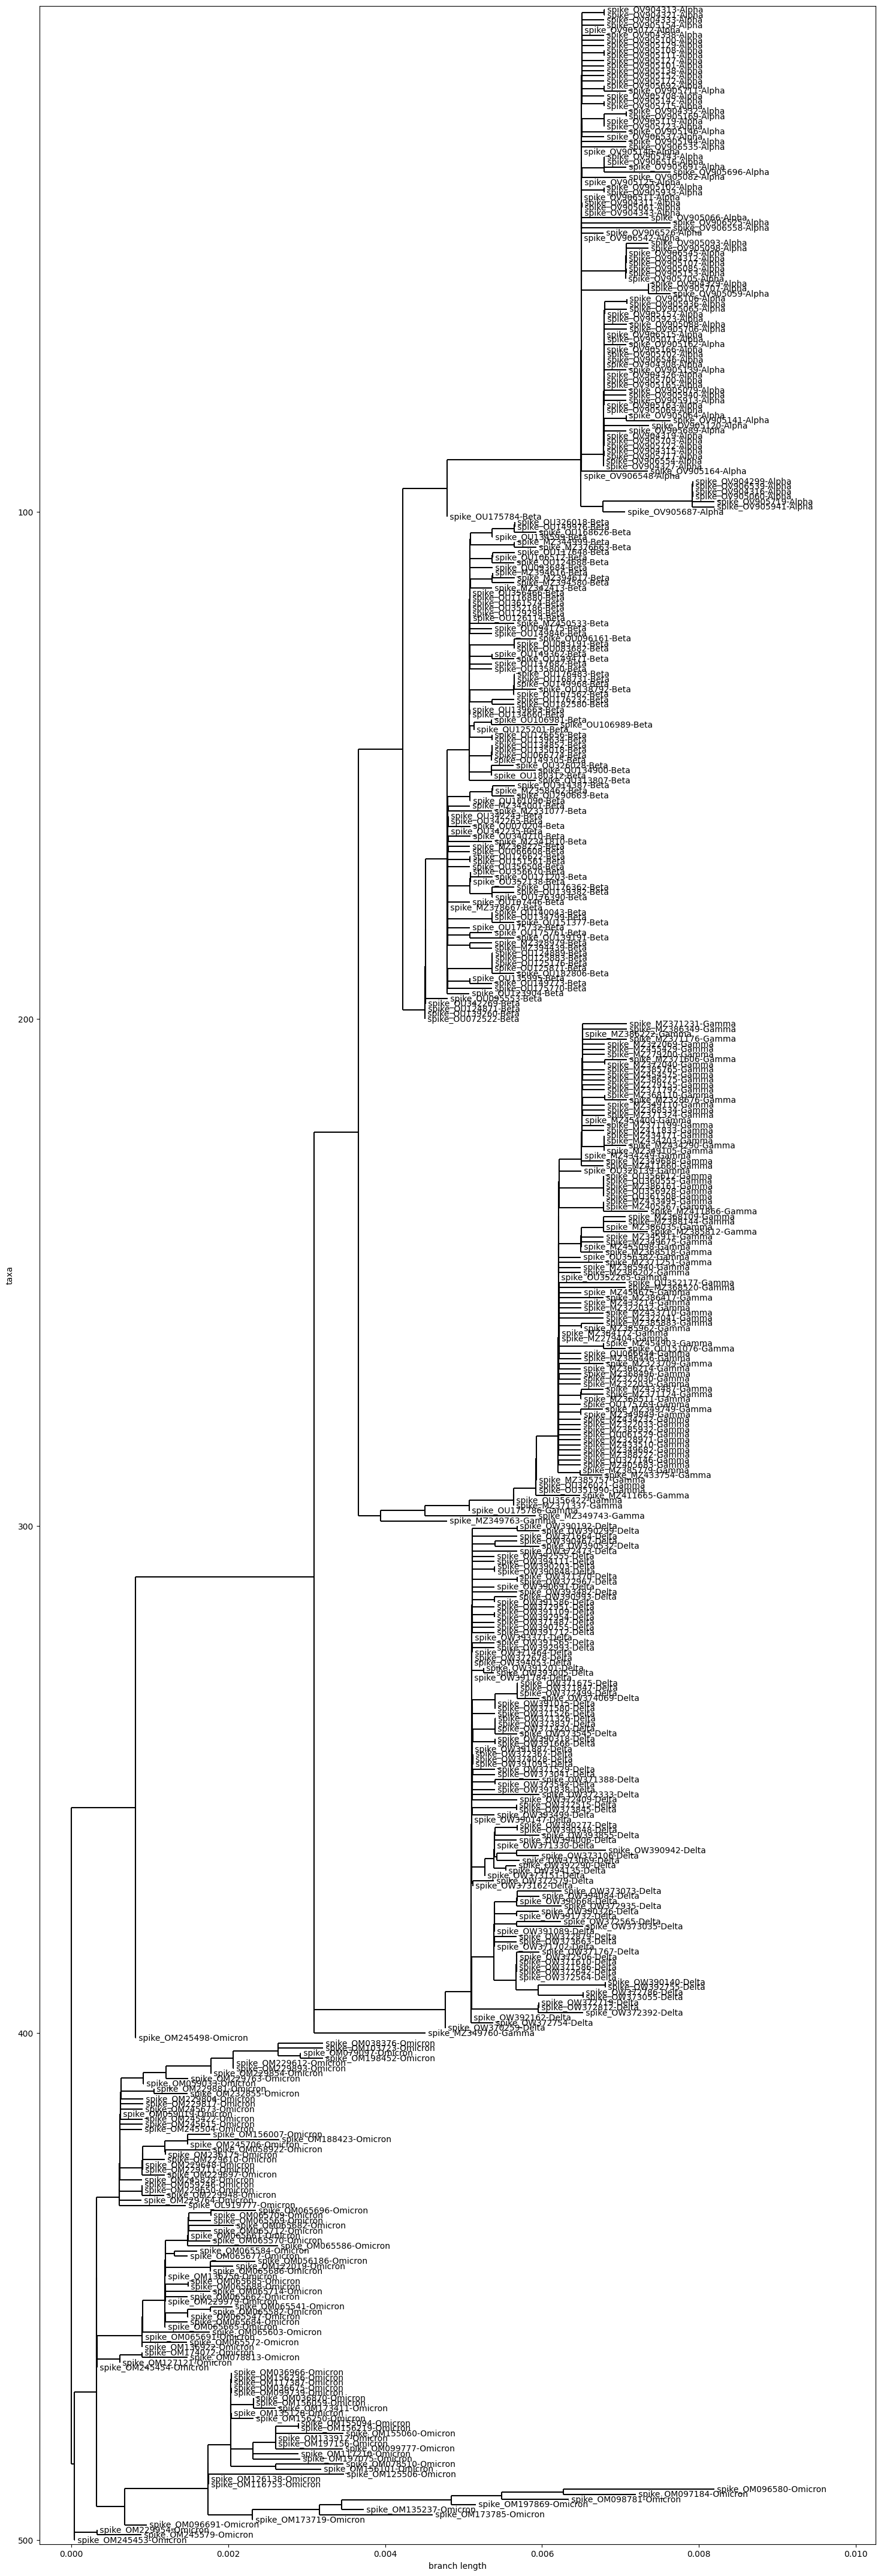

O número de sequências na árvore é: 500
A profundidade máxima da árvore é: 33


In [2]:
# Função recursiva para calcular a profundidade de cada nó
def calcular_profundidade(clado, profundidade_atual):
    clado.profundidade = profundidade_atual
    for clado_filho in clado.clades:
        calcular_profundidade(clado_filho, profundidade_atual + 1)

# Carregue a árvore a partir do arquivo
arvore = Phylo.read("/home/m_souza/tcc/dataset/dataset_agua/iqtree/sequencias_treinamento.fasta.nwk", "newick")

# Plote a árvore
# Crie uma figura com tamanho personalizado
fig, ax = plt.subplots(figsize=(18, 55))  # Ajuste o tamanho conforme desejado

# Plote a árvore
Phylo.draw(arvore, axes=ax, label_func=lambda x: '' if not x.is_terminal() else x.name)
# ax.set_title("UPGMA TREE", y=1.02)
# Exiba o gráfico
plt.show()

# Inicialize uma variável para contar o número de sequências
numero_de_sequencias = 0

# Percorra os clados da árvore
for clado in arvore.find_clades():
    # Verifique se o clado é um clado terminal (folha)
    if clado.is_terminal():
        numero_de_sequencias += 1

# Imprima o número de sequências
print(f"O número de sequências na árvore é: {numero_de_sequencias}")

# Inicialize a raiz com profundidade 0
calcular_profundidade(arvore.root, 0)

# Dicionário para armazenar a profundidade de cada nó
profundidade_por_no = {}

# Percorra os clados da árvore e armazene a profundidade de cada nó
for clado in arvore.find_clades():
    profundidade_por_no[clado] = clado.profundidade

# Determine a profundidade máxima na árvore
profundidade_maxima = max(profundidade_por_no.values())

print(f"A profundidade máxima da árvore é: {profundidade_maxima}")

# CHECK - OK  Determine a profundidade máxima na árvore
# profundidade_maxima = max(clado.profundidade for clado in arvore.find_clades())

# print(f"2. A profundidade máxima da árvore é: {profundidade_maxima}")

# PROCESSO DE OTIMIZAÇÃO DO NUMERO DE CLUSTERS

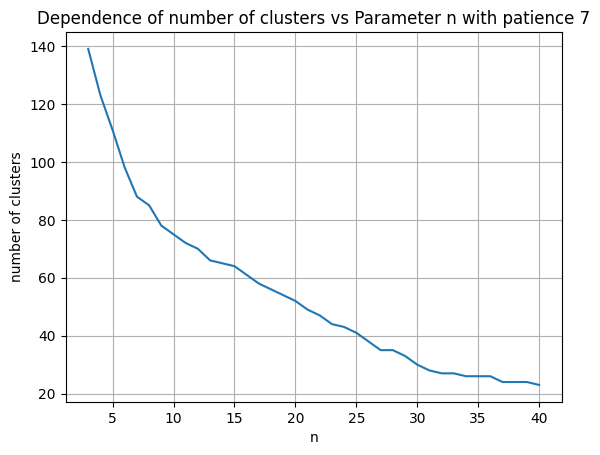

the process converged to  23  clusters with patience  7


In [27]:
# Funções para definir o estado de associação dos nós
def definir_estados_arvore(arvore, n):
    # inicialização
    ctr=0 # root node
    for no in arvore.traverse("preorder"):
        no.add_features(estado=0) # não visitado
        if no.is_leaf():
            no.estado=2  # todos os nós folhas são filhos
        if no.name=="":
            no.name="Inner"+str(ctr)
            ctr+=1
    # Começando da raiz identificando nós pais dos clusters
    for no in arvore.traverse("preorder"):
#         if no.name=="":
#             print("inner node")
#         else:
#             print(no.name)
        if no.estado==0: # não visitado
            nós_internos_totais = no.get_descendants()
            nós_internos_sem_folhas = [nó for nó in nós_internos_totais if not nó.is_leaf()]
            nós_internos = len(nós_internos_sem_folhas)
            if 0 <= nós_internos < n:
#                 print("considerado pai ")
                no.estado = 1  # Nó pai
                # marcar como visitados todos os nós internos filhos
                for no_interno in nós_internos_sem_folhas:
                    no_interno.estado = 3
            else:
#                 print("nao considerado pai, mas marcado como visitado ")
                no.estado = 3  # visitado

# Definir o número máximo de nós filhos permitidos (parâmetro "n")
Nclusters=[]
nPrm=[]
nmin=3
nmax=40

patience = 7 # for convergence assumption - de patience 5 para 6 há uma mudnça brava no numero de clusters

for n in range(nmin,nmax+1):

    arvore3 = Ete3Tree("/home/m_souza/tcc/dataset/dataset_agua/iqtree/sequencias_treinamento.fasta.nwk",format=1)

    # Definir estados de associação
    definir_estados_arvore(arvore3, n)

    # Inicialize contadores
    contagem_estado_1 = 0
    contagem_estado_2 = 0

    # Percorra os nós da árvore
    for no in arvore3.traverse('preorder'):
        estado = no.estado  # Supondo que o campo "estado" está definido em cada nó
        if estado == 1:
            contagem_estado_1 += 1
        elif estado == 2:
            contagem_estado_2 += 1

    # Exiba os resultados

    Nclusters.append(contagem_estado_1)
    nPrm.append(n)
    if len(Nclusters) > patience: # quantos dados do passado vou considerar
        ctr=1
        for p in range(1,patience+1):
            if Nclusters[-1]==Nclusters[-p-1]:
                ctr += 1
            else:
                break
        if ctr >= patience:
            break

plt.plot(nPrm,Nclusters)
plt.grid()
plt.xlabel("n")
plt.ylabel("number of clusters")
plt.title("Dependence of number of clusters vs Parameter n with patience "+str(patience))
plt.show()

print("the process converged to ",Nclusters[-1]," clusters with patience ",patience)

In [4]:
# listando os clusters
nclusters = 0
Clusters = {}
for no in arvore3.traverse("preorder"):
#         if no.name=="":
#             print("inner node")
#         else:
#             print(no.name)
    if no.estado == 1: # nó pai
        nos_internos_totais = no.get_descendants()
        cluster = [] # lista de accession no cluster
        for nodo in nos_internos_totais:
            if nodo.is_leaf():
#                 print('nodo.name ',nodo.name)
                nodo.name = nodo.name+":"+str(nclusters)
                cluster.append(nodo.name)
        Clusters[nclusters] = cluster # adiciona o cluster ao dicionario
        nclusters += 1 # incrementa contador de clusters

# Definir um estilo para a plotagem da árvore
ts = TreeStyle()
ts.show_leaf_name = True

# salva a árvore para um arquivo PNG
x = arvore3.render("arvore_UPGMA_anotada.png", tree_style=ts)

QSocketNotifier: Can only be used with threads started with QThread


In [5]:
# print(Clusters)
# Determine o comprimento da lista mais longa
comprimento_maximo = max(len(valor) for valor in Clusters.values())

# Preencha as listas com valores vazios para que tenham o mesmo comprimento
for chave, valor in Clusters.items():
    while len(valor) < comprimento_maximo:
        valor.append("")

# Imprima o dicionário como uma tabela

tabela = tabulate(Clusters, headers='keys', tablefmt='pretty')

# Imprima a tabela reduzida e transposta
# print(tabela)
print(tabulate(Clusters, headers='keys', tablefmt='pretty'))

# # Imprima o dicionário como uma tabela em HTML
# tabela_html = tabulate(Clusters, headers='keys', tablefmt='html')

# # Adicione um estilo CSS para reduzir o tamanho da fonte
# tabela_html_com_css = tabela_html.replace("<table>", '<table style="font-size: 7px;">')

# # Imprima a tabela em HTML com tamanho de fonte reduzido
# print(tabela_html_com_css)

+------------------------+------------------------+------------------------+------------------------+------------------------+-----------------------+-----------------------+-----------------------+-----------------------+------------------------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+---------------------------+---------------------------+---------------------------+---------------------------+
|           0            |           1            |           2            |           3            |           4            |           5           |           6           |           7           |           8           |           9            |           10            |           11            |           12            |           13            |           14            |           15            |   